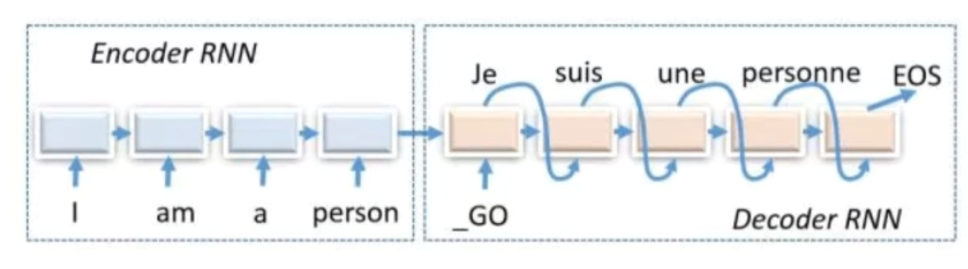

In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K

In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

### Start Input line with (Start of Sentence) and Target line with (End of Sentence)

In [4]:
# load in the data
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue

    input_line = '<sos> ' + line
    target_line = line + ' <eos>'

    input_texts.append(input_line)
    target_texts.append(target_line)

In [5]:
all_lines = input_texts + target_texts

In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [7]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [10]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join(r'glove6d/glove.6B.50d.txt'),encoding='utf-8') as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [11]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [12]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1
print("Shape of One-Hot Vector is ...", one_hot_targets.shape)

Shape of One-Hot Vector is ... (1436, 12, 3000)


In [13]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

In [14]:
print('Building model...')
# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)
model = Model([input_, initial_h, initial_c], output)
model.summary()
model.compile( loss='categorical_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])

Building model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12, 50)       150000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25)]         0                                            
____________________________________________________________________________

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit([input_sequences, z, z], one_hot_targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Training model...
Epoch 1/2000
9/9 [==============================] - 6s 110ms/step - loss: 5.3553 - accuracy: 0.0192 - val_loss: 4.9939 - val_accuracy: 0.0796
Epoch 2/2000
9/9 [==============================] - 0s 42ms/step - loss: 4.5670 - accuracy: 0.0836 - val_loss: 4.7366 - val_accuracy: 0.0833
Epoch 3/2000
9/9 [==============================] - 0s 43ms/step - loss: 4.3700 - accuracy: 0.0833 - val_loss: 4.7868 - val_accuracy: 0.0833
Epoch 4/2000
9/9 [==============================] - 0s 43ms/step - loss: 4.3252 - accuracy: 0.0833 - val_loss: 4.8125 - val_accuracy: 0.0833
Epoch 5/2000
9/9 [==============================] - 0s 42ms/step - loss: 4.3092 - accuracy: 0.0833 - val_loss: 4.7853 - val_accuracy: 0.0833
Epoch 6/2000
9/9 [==============================] - 0s 42ms/step - loss: 4.2670 - accuracy: 0.0833 - val_loss: 4.7292 - val_accuracy: 0.0833
Epoch 7/2000
9/9 [==============================] - 0s 43ms/step - loss: 4.2238 - accuracy: 0.0833 - val_loss: 4.6864 - val_accuracy: 0

9/9 [==============================] - 0s 45ms/step - loss: 3.1564 - accuracy: 0.1763 - val_loss: 4.8785 - val_accuracy: 0.0909
Epoch 59/2000
9/9 [==============================] - 0s 43ms/step - loss: 3.1419 - accuracy: 0.1781 - val_loss: 4.8751 - val_accuracy: 0.0920
Epoch 60/2000
9/9 [==============================] - 0s 44ms/step - loss: 3.1267 - accuracy: 0.1788 - val_loss: 4.8853 - val_accuracy: 0.0900
Epoch 61/2000
9/9 [==============================] - 0s 43ms/step - loss: 3.1085 - accuracy: 0.1810 - val_loss: 4.8897 - val_accuracy: 0.0897
Epoch 62/2000
9/9 [==============================] - 0s 44ms/step - loss: 3.0934 - accuracy: 0.1833 - val_loss: 4.9047 - val_accuracy: 0.0906
Epoch 63/2000
9/9 [==============================] - 0s 43ms/step - loss: 3.0778 - accuracy: 0.1850 - val_loss: 4.9088 - val_accuracy: 0.0906
Epoch 64/2000
9/9 [==============================] - 0s 46ms/step - loss: 3.0628 - accuracy: 0.1850 - val_loss: 4.9227 - val_accuracy: 0.0891
Epoch 65/2000
9/9 [=

Epoch 116/2000
9/9 [==============================] - 0s 43ms/step - loss: 2.3799 - accuracy: 0.2454 - val_loss: 5.3297 - val_accuracy: 0.0868
Epoch 117/2000
9/9 [==============================] - 0s 43ms/step - loss: 2.3721 - accuracy: 0.2488 - val_loss: 5.3483 - val_accuracy: 0.0862
Epoch 118/2000
9/9 [==============================] - 0s 42ms/step - loss: 2.3635 - accuracy: 0.2477 - val_loss: 5.3530 - val_accuracy: 0.0871
Epoch 119/2000
9/9 [==============================] - 0s 43ms/step - loss: 2.3550 - accuracy: 0.2487 - val_loss: 5.3712 - val_accuracy: 0.0877
Epoch 120/2000
9/9 [==============================] - 0s 43ms/step - loss: 2.3474 - accuracy: 0.2504 - val_loss: 5.3816 - val_accuracy: 0.0885
Epoch 121/2000
9/9 [==============================] - 0s 43ms/step - loss: 2.3365 - accuracy: 0.2526 - val_loss: 5.3877 - val_accuracy: 0.0859
Epoch 122/2000
9/9 [==============================] - 0s 43ms/step - loss: 2.3262 - accuracy: 0.2523 - val_loss: 5.4061 - val_accuracy: 0.0877

9/9 [==============================] - 0s 43ms/step - loss: 1.9878 - accuracy: 0.2960 - val_loss: 6.0238 - val_accuracy: 0.0813
Epoch 174/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.9905 - accuracy: 0.2967 - val_loss: 6.0254 - val_accuracy: 0.0830
Epoch 175/2000
9/9 [==============================] - 0s 45ms/step - loss: 1.9832 - accuracy: 0.2986 - val_loss: 6.0448 - val_accuracy: 0.0830
Epoch 176/2000
9/9 [==============================] - 0s 42ms/step - loss: 1.9763 - accuracy: 0.2992 - val_loss: 6.0650 - val_accuracy: 0.0825
Epoch 177/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.9709 - accuracy: 0.2977 - val_loss: 6.0888 - val_accuracy: 0.0822
Epoch 178/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.9680 - accuracy: 0.3012 - val_loss: 6.0495 - val_accuracy: 0.0842
Epoch 179/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.9617 - accuracy: 0.3023 - val_loss: 6.0756 - val_accuracy: 0.0810
Epoch 180/2000

9/9 [==============================] - 0s 43ms/step - loss: 1.7283 - accuracy: 0.3408 - val_loss: 6.7836 - val_accuracy: 0.0793
Epoch 231/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.7223 - accuracy: 0.3407 - val_loss: 6.7791 - val_accuracy: 0.0796
Epoch 232/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.7176 - accuracy: 0.3431 - val_loss: 6.7916 - val_accuracy: 0.0784
Epoch 233/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.7158 - accuracy: 0.3437 - val_loss: 6.7984 - val_accuracy: 0.0793
Epoch 234/2000
9/9 [==============================] - 0s 45ms/step - loss: 1.7155 - accuracy: 0.3401 - val_loss: 6.8188 - val_accuracy: 0.0781
Epoch 235/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.7110 - accuracy: 0.3444 - val_loss: 6.8348 - val_accuracy: 0.0796
Epoch 236/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.7063 - accuracy: 0.3428 - val_loss: 6.8551 - val_accuracy: 0.0793
Epoch 237/2000

9/9 [==============================] - 0s 43ms/step - loss: 1.5712 - accuracy: 0.3652 - val_loss: 7.6244 - val_accuracy: 0.0738
Epoch 288/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.5609 - accuracy: 0.3701 - val_loss: 7.5834 - val_accuracy: 0.0770
Epoch 289/2000
9/9 [==============================] - 0s 42ms/step - loss: 1.5555 - accuracy: 0.3712 - val_loss: 7.6356 - val_accuracy: 0.0752
Epoch 290/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.5501 - accuracy: 0.3722 - val_loss: 7.6451 - val_accuracy: 0.0761
Epoch 291/2000
9/9 [==============================] - 0s 42ms/step - loss: 1.5483 - accuracy: 0.3727 - val_loss: 7.6586 - val_accuracy: 0.0749
Epoch 292/2000
9/9 [==============================] - 0s 42ms/step - loss: 1.5415 - accuracy: 0.3746 - val_loss: 7.6709 - val_accuracy: 0.0747
Epoch 293/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.5413 - accuracy: 0.3738 - val_loss: 7.7098 - val_accuracy: 0.0749
Epoch 294/2000

9/9 [==============================] - 0s 43ms/step - loss: 1.4233 - accuracy: 0.3963 - val_loss: 8.4873 - val_accuracy: 0.0723
Epoch 345/2000
9/9 [==============================] - 0s 46ms/step - loss: 1.4236 - accuracy: 0.3978 - val_loss: 8.5563 - val_accuracy: 0.0715
Epoch 346/2000
9/9 [==============================] - 0s 47ms/step - loss: 1.4175 - accuracy: 0.4015 - val_loss: 8.5119 - val_accuracy: 0.0709
Epoch 347/2000
9/9 [==============================] - 0s 45ms/step - loss: 1.4145 - accuracy: 0.4011 - val_loss: 8.5573 - val_accuracy: 0.0715
Epoch 348/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.4164 - accuracy: 0.3997 - val_loss: 8.5730 - val_accuracy: 0.0715
Epoch 349/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.4192 - accuracy: 0.3997 - val_loss: 8.5849 - val_accuracy: 0.0729
Epoch 350/2000
9/9 [==============================] - 0s 45ms/step - loss: 1.4304 - accuracy: 0.3961 - val_loss: 8.6198 - val_accuracy: 0.0712
Epoch 351/2000

9/9 [==============================] - 0s 44ms/step - loss: 1.3300 - accuracy: 0.4172 - val_loss: 9.4118 - val_accuracy: 0.0697
Epoch 402/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.3312 - accuracy: 0.4160 - val_loss: 9.3551 - val_accuracy: 0.0720
Epoch 403/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.3297 - accuracy: 0.4179 - val_loss: 9.4609 - val_accuracy: 0.0700
Epoch 404/2000
9/9 [==============================] - 0s 52ms/step - loss: 1.3301 - accuracy: 0.4167 - val_loss: 9.4391 - val_accuracy: 0.0712
Epoch 405/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.3285 - accuracy: 0.4187 - val_loss: 9.4867 - val_accuracy: 0.0709
Epoch 406/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.3296 - accuracy: 0.4175 - val_loss: 9.4641 - val_accuracy: 0.0720
Epoch 407/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.3282 - accuracy: 0.4193 - val_loss: 9.5251 - val_accuracy: 0.0700
Epoch 408/2000

9/9 [==============================] - 0s 44ms/step - loss: 1.2583 - accuracy: 0.4327 - val_loss: 10.3546 - val_accuracy: 0.0697
Epoch 459/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.2571 - accuracy: 0.4326 - val_loss: 10.3155 - val_accuracy: 0.0712
Epoch 460/2000
9/9 [==============================] - 0s 49ms/step - loss: 1.2553 - accuracy: 0.4318 - val_loss: 10.3269 - val_accuracy: 0.0694
Epoch 461/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.2532 - accuracy: 0.4345 - val_loss: 10.3844 - val_accuracy: 0.0703
Epoch 462/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.2511 - accuracy: 0.4345 - val_loss: 10.3990 - val_accuracy: 0.0689
Epoch 463/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.2508 - accuracy: 0.4313 - val_loss: 10.3949 - val_accuracy: 0.0715
Epoch 464/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.2535 - accuracy: 0.4328 - val_loss: 10.4311 - val_accuracy: 0.0680
Epoch 4

Epoch 515/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.2127 - accuracy: 0.4398 - val_loss: 11.1403 - val_accuracy: 0.0694
Epoch 516/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.2112 - accuracy: 0.4384 - val_loss: 11.1353 - val_accuracy: 0.0694
Epoch 517/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.2179 - accuracy: 0.4374 - val_loss: 11.1933 - val_accuracy: 0.0689
Epoch 518/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.2135 - accuracy: 0.4385 - val_loss: 11.1763 - val_accuracy: 0.0715
Epoch 519/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.2109 - accuracy: 0.4387 - val_loss: 11.1742 - val_accuracy: 0.0712
Epoch 520/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.2082 - accuracy: 0.4384 - val_loss: 11.2351 - val_accuracy: 0.0686
Epoch 521/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.2004 - accuracy: 0.4419 - val_loss: 11.2293 - val_accuracy:

Epoch 572/2000
9/9 [==============================] - 0s 45ms/step - loss: 1.1524 - accuracy: 0.4535 - val_loss: 12.0596 - val_accuracy: 0.0666
Epoch 573/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.1560 - accuracy: 0.4506 - val_loss: 12.1136 - val_accuracy: 0.0654
Epoch 574/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.1498 - accuracy: 0.4544 - val_loss: 12.1916 - val_accuracy: 0.0660
Epoch 575/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.1533 - accuracy: 0.4528 - val_loss: 12.1874 - val_accuracy: 0.0692
Epoch 576/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.1560 - accuracy: 0.4519 - val_loss: 12.1280 - val_accuracy: 0.0663
Epoch 577/2000
9/9 [==============================] - 0s 45ms/step - loss: 1.1600 - accuracy: 0.4530 - val_loss: 12.2057 - val_accuracy: 0.0674
Epoch 578/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.1576 - accuracy: 0.4501 - val_loss: 12.1314 - val_accuracy:

Epoch 629/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.1181 - accuracy: 0.4601 - val_loss: 13.0119 - val_accuracy: 0.0625
Epoch 630/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.1221 - accuracy: 0.4607 - val_loss: 12.9577 - val_accuracy: 0.0677
Epoch 631/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.1288 - accuracy: 0.4564 - val_loss: 12.9865 - val_accuracy: 0.0651
Epoch 632/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.1237 - accuracy: 0.4594 - val_loss: 12.9815 - val_accuracy: 0.0657
Epoch 633/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.1227 - accuracy: 0.4604 - val_loss: 13.0270 - val_accuracy: 0.0648
Epoch 634/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.1197 - accuracy: 0.4599 - val_loss: 13.0221 - val_accuracy: 0.0666
Epoch 635/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.1546 - accuracy: 0.4516 - val_loss: 13.0659 - val_accuracy:

Epoch 686/2000
9/9 [==============================] - 0s 46ms/step - loss: 1.0773 - accuracy: 0.4686 - val_loss: 13.8378 - val_accuracy: 0.0634
Epoch 687/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0743 - accuracy: 0.4681 - val_loss: 13.8974 - val_accuracy: 0.0619
Epoch 688/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0756 - accuracy: 0.4677 - val_loss: 13.8862 - val_accuracy: 0.0631
Epoch 689/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0688 - accuracy: 0.4696 - val_loss: 13.8913 - val_accuracy: 0.0631
Epoch 690/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0672 - accuracy: 0.4715 - val_loss: 13.8940 - val_accuracy: 0.0625
Epoch 691/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0573 - accuracy: 0.4736 - val_loss: 13.8759 - val_accuracy: 0.0622
Epoch 692/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0612 - accuracy: 0.4718 - val_loss: 13.9101 - val_accuracy:

Epoch 743/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0356 - accuracy: 0.4770 - val_loss: 14.7679 - val_accuracy: 0.0619
Epoch 744/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0414 - accuracy: 0.4777 - val_loss: 14.7334 - val_accuracy: 0.0611
Epoch 745/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0438 - accuracy: 0.4752 - val_loss: 14.8148 - val_accuracy: 0.0622
Epoch 746/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0555 - accuracy: 0.4755 - val_loss: 14.8274 - val_accuracy: 0.0625
Epoch 747/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0539 - accuracy: 0.4735 - val_loss: 14.7968 - val_accuracy: 0.0616
Epoch 748/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0592 - accuracy: 0.4721 - val_loss: 14.7823 - val_accuracy: 0.0631
Epoch 749/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0599 - accuracy: 0.4718 - val_loss: 14.8131 - val_accuracy:

Epoch 800/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0180 - accuracy: 0.4802 - val_loss: 15.5653 - val_accuracy: 0.0631
Epoch 801/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0120 - accuracy: 0.4830 - val_loss: 15.6415 - val_accuracy: 0.0625
Epoch 802/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0123 - accuracy: 0.4824 - val_loss: 15.5769 - val_accuracy: 0.0628
Epoch 803/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0147 - accuracy: 0.4800 - val_loss: 15.5372 - val_accuracy: 0.0628
Epoch 804/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0259 - accuracy: 0.4803 - val_loss: 15.6324 - val_accuracy: 0.0648
Epoch 805/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0225 - accuracy: 0.4797 - val_loss: 15.6401 - val_accuracy: 0.0613
Epoch 806/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0219 - accuracy: 0.4791 - val_loss: 15.6368 - val_accuracy:

Epoch 857/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0088 - accuracy: 0.4802 - val_loss: 16.3592 - val_accuracy: 0.0631
Epoch 858/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0146 - accuracy: 0.4811 - val_loss: 16.3909 - val_accuracy: 0.0631
Epoch 859/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0242 - accuracy: 0.4815 - val_loss: 16.3971 - val_accuracy: 0.0622
Epoch 860/2000
9/9 [==============================] - 0s 42ms/step - loss: 1.0259 - accuracy: 0.4797 - val_loss: 16.3896 - val_accuracy: 0.0613
Epoch 861/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0163 - accuracy: 0.4783 - val_loss: 16.3235 - val_accuracy: 0.0622
Epoch 862/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0133 - accuracy: 0.4791 - val_loss: 16.3422 - val_accuracy: 0.0625
Epoch 863/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0208 - accuracy: 0.4779 - val_loss: 16.4535 - val_accuracy:

Epoch 914/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9837 - accuracy: 0.4866 - val_loss: 17.1014 - val_accuracy: 0.0596
Epoch 915/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9773 - accuracy: 0.4873 - val_loss: 17.1372 - val_accuracy: 0.0608
Epoch 916/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9751 - accuracy: 0.4878 - val_loss: 17.1776 - val_accuracy: 0.0605
Epoch 917/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9781 - accuracy: 0.4903 - val_loss: 17.1046 - val_accuracy: 0.0602
Epoch 918/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9737 - accuracy: 0.4909 - val_loss: 17.1767 - val_accuracy: 0.0613
Epoch 919/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9686 - accuracy: 0.4919 - val_loss: 17.2641 - val_accuracy: 0.0584
Epoch 920/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9670 - accuracy: 0.4918 - val_loss: 17.2102 - val_accuracy:

Epoch 971/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9641 - accuracy: 0.4903 - val_loss: 17.9652 - val_accuracy: 0.0590
Epoch 972/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9659 - accuracy: 0.4906 - val_loss: 17.9448 - val_accuracy: 0.0602
Epoch 973/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9617 - accuracy: 0.4908 - val_loss: 18.0027 - val_accuracy: 0.0587
Epoch 974/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9555 - accuracy: 0.4917 - val_loss: 18.0144 - val_accuracy: 0.0582
Epoch 975/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9577 - accuracy: 0.4921 - val_loss: 18.0174 - val_accuracy: 0.0596
Epoch 976/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9542 - accuracy: 0.4898 - val_loss: 18.0633 - val_accuracy: 0.0582
Epoch 977/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9500 - accuracy: 0.4933 - val_loss: 18.0254 - val_accuracy:

Epoch 1028/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9760 - accuracy: 0.4866 - val_loss: 18.5964 - val_accuracy: 0.0608
Epoch 1029/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9976 - accuracy: 0.4802 - val_loss: 18.7481 - val_accuracy: 0.0608
Epoch 1030/2000
9/9 [==============================] - 0s 43ms/step - loss: 1.0185 - accuracy: 0.4769 - val_loss: 18.6575 - val_accuracy: 0.0584
Epoch 1031/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0098 - accuracy: 0.4785 - val_loss: 18.7399 - val_accuracy: 0.0570
Epoch 1032/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0175 - accuracy: 0.4750 - val_loss: 18.5945 - val_accuracy: 0.0605
Epoch 1033/2000
9/9 [==============================] - 0s 44ms/step - loss: 1.0147 - accuracy: 0.4771 - val_loss: 18.7128 - val_accuracy: 0.0596
Epoch 1034/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9871 - accuracy: 0.4840 - val_loss: 18.7958 - val_ac

9/9 [==============================] - 0s 44ms/step - loss: 0.9723 - accuracy: 0.4861 - val_loss: 19.3652 - val_accuracy: 0.0576
Epoch 1085/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9586 - accuracy: 0.4883 - val_loss: 19.3895 - val_accuracy: 0.0596
Epoch 1086/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9531 - accuracy: 0.4898 - val_loss: 19.3940 - val_accuracy: 0.0587
Epoch 1087/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9484 - accuracy: 0.4938 - val_loss: 19.3605 - val_accuracy: 0.0587
Epoch 1088/2000
9/9 [==============================] - 0s 45ms/step - loss: 0.9498 - accuracy: 0.4891 - val_loss: 19.3662 - val_accuracy: 0.0584
Epoch 1089/2000
9/9 [==============================] - 0s 46ms/step - loss: 0.9515 - accuracy: 0.4910 - val_loss: 19.3799 - val_accuracy: 0.0570
Epoch 1090/2000
9/9 [==============================] - 0s 48ms/step - loss: 0.9455 - accuracy: 0.4915 - val_loss: 19.5037 - val_accuracy: 0.0584
E

9/9 [==============================] - 0s 43ms/step - loss: 0.9300 - accuracy: 0.4975 - val_loss: 20.0123 - val_accuracy: 0.0570
Epoch 1141/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9346 - accuracy: 0.4972 - val_loss: 20.1263 - val_accuracy: 0.0582
Epoch 1142/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9290 - accuracy: 0.4979 - val_loss: 20.0296 - val_accuracy: 0.0567
Epoch 1143/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.9308 - accuracy: 0.4967 - val_loss: 20.0210 - val_accuracy: 0.0573
Epoch 1144/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9342 - accuracy: 0.4964 - val_loss: 20.1304 - val_accuracy: 0.0567
Epoch 1145/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9525 - accuracy: 0.4907 - val_loss: 20.0648 - val_accuracy: 0.0576
Epoch 1146/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9537 - accuracy: 0.4885 - val_loss: 20.1392 - val_accuracy: 0.0541
E

9/9 [==============================] - 0s 43ms/step - loss: 0.9484 - accuracy: 0.4915 - val_loss: 20.8498 - val_accuracy: 0.0558
Epoch 1197/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9270 - accuracy: 0.4954 - val_loss: 20.8518 - val_accuracy: 0.0564
Epoch 1198/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9267 - accuracy: 0.4945 - val_loss: 20.7919 - val_accuracy: 0.0573
Epoch 1199/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9261 - accuracy: 0.4984 - val_loss: 20.7373 - val_accuracy: 0.0576
Epoch 1200/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9481 - accuracy: 0.4930 - val_loss: 20.8418 - val_accuracy: 0.0590
Epoch 1201/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9408 - accuracy: 0.4946 - val_loss: 20.8641 - val_accuracy: 0.0561
Epoch 1202/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9343 - accuracy: 0.4922 - val_loss: 20.9557 - val_accuracy: 0.0558
E

9/9 [==============================] - 0s 43ms/step - loss: 0.9580 - accuracy: 0.4845 - val_loss: 21.2978 - val_accuracy: 0.0582
Epoch 1253/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9461 - accuracy: 0.4894 - val_loss: 21.2945 - val_accuracy: 0.0590
Epoch 1254/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.9567 - accuracy: 0.4865 - val_loss: 21.3298 - val_accuracy: 0.0599
Epoch 1255/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9493 - accuracy: 0.4895 - val_loss: 21.3414 - val_accuracy: 0.0582
Epoch 1256/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9392 - accuracy: 0.4895 - val_loss: 21.3687 - val_accuracy: 0.0573
Epoch 1257/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9302 - accuracy: 0.4932 - val_loss: 21.3355 - val_accuracy: 0.0567
Epoch 1258/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9281 - accuracy: 0.4948 - val_loss: 21.4670 - val_accuracy: 0.0567
E

9/9 [==============================] - 0s 42ms/step - loss: 0.9354 - accuracy: 0.4905 - val_loss: 21.8866 - val_accuracy: 0.0602
Epoch 1309/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.9328 - accuracy: 0.4898 - val_loss: 21.9863 - val_accuracy: 0.0587
Epoch 1310/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9255 - accuracy: 0.4946 - val_loss: 21.8780 - val_accuracy: 0.0579
Epoch 1311/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9319 - accuracy: 0.4932 - val_loss: 22.0334 - val_accuracy: 0.0576
Epoch 1312/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9458 - accuracy: 0.4927 - val_loss: 22.0344 - val_accuracy: 0.0564
Epoch 1313/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.9693 - accuracy: 0.4859 - val_loss: 22.0489 - val_accuracy: 0.0582
Epoch 1314/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9835 - accuracy: 0.4832 - val_loss: 21.9535 - val_accuracy: 0.0593
E

9/9 [==============================] - 0s 43ms/step - loss: 0.8924 - accuracy: 0.5020 - val_loss: 22.7326 - val_accuracy: 0.0576
Epoch 1365/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8842 - accuracy: 0.5033 - val_loss: 22.7193 - val_accuracy: 0.0564
Epoch 1366/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8834 - accuracy: 0.5060 - val_loss: 22.6199 - val_accuracy: 0.0579
Epoch 1367/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8815 - accuracy: 0.5073 - val_loss: 22.7606 - val_accuracy: 0.0582
Epoch 1368/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.8801 - accuracy: 0.5063 - val_loss: 22.7171 - val_accuracy: 0.0570
Epoch 1369/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8871 - accuracy: 0.5028 - val_loss: 22.7066 - val_accuracy: 0.0584
Epoch 1370/2000
9/9 [==============================] - 0s 45ms/step - loss: 0.8805 - accuracy: 0.5030 - val_loss: 22.6175 - val_accuracy: 0.0576
E

9/9 [==============================] - 0s 45ms/step - loss: 0.9108 - accuracy: 0.4985 - val_loss: 23.1898 - val_accuracy: 0.0582
Epoch 1421/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9095 - accuracy: 0.4961 - val_loss: 23.2821 - val_accuracy: 0.0584
Epoch 1422/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9088 - accuracy: 0.4985 - val_loss: 23.2145 - val_accuracy: 0.0573
Epoch 1423/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.9032 - accuracy: 0.4988 - val_loss: 23.3956 - val_accuracy: 0.0576
Epoch 1424/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8900 - accuracy: 0.5001 - val_loss: 23.2785 - val_accuracy: 0.0596
Epoch 1425/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8815 - accuracy: 0.5037 - val_loss: 23.2859 - val_accuracy: 0.0584
Epoch 1426/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8715 - accuracy: 0.5060 - val_loss: 23.3524 - val_accuracy: 0.0584
E

9/9 [==============================] - 0s 43ms/step - loss: 0.8740 - accuracy: 0.5062 - val_loss: 23.8162 - val_accuracy: 0.0561
Epoch 1477/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8679 - accuracy: 0.5061 - val_loss: 23.7336 - val_accuracy: 0.0579
Epoch 1478/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8718 - accuracy: 0.5055 - val_loss: 23.8052 - val_accuracy: 0.0556
Epoch 1479/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8660 - accuracy: 0.5085 - val_loss: 23.8721 - val_accuracy: 0.0561
Epoch 1480/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8627 - accuracy: 0.5090 - val_loss: 23.8865 - val_accuracy: 0.0550
Epoch 1481/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8601 - accuracy: 0.5113 - val_loss: 23.7187 - val_accuracy: 0.0570
Epoch 1482/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8568 - accuracy: 0.5083 - val_loss: 23.8544 - val_accuracy: 0.0564
E

9/9 [==============================] - 0s 43ms/step - loss: 0.8976 - accuracy: 0.5003 - val_loss: 24.3123 - val_accuracy: 0.0527
Epoch 1533/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8909 - accuracy: 0.5015 - val_loss: 24.2836 - val_accuracy: 0.0515
Epoch 1534/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8840 - accuracy: 0.5025 - val_loss: 24.2987 - val_accuracy: 0.0524
Epoch 1535/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8886 - accuracy: 0.5001 - val_loss: 24.1716 - val_accuracy: 0.0553
Epoch 1536/2000
9/9 [==============================] - 0s 45ms/step - loss: 0.8902 - accuracy: 0.5012 - val_loss: 24.2236 - val_accuracy: 0.0550
Epoch 1537/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8866 - accuracy: 0.5020 - val_loss: 24.3065 - val_accuracy: 0.0530
Epoch 1538/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8796 - accuracy: 0.5019 - val_loss: 24.4690 - val_accuracy: 0.0550
E

9/9 [==============================] - 0s 42ms/step - loss: 0.8801 - accuracy: 0.5011 - val_loss: 24.7770 - val_accuracy: 0.0538
Epoch 1589/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8773 - accuracy: 0.5025 - val_loss: 24.9811 - val_accuracy: 0.0547
Epoch 1590/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8708 - accuracy: 0.5055 - val_loss: 24.9211 - val_accuracy: 0.0532
Epoch 1591/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8789 - accuracy: 0.5021 - val_loss: 24.9833 - val_accuracy: 0.0524
Epoch 1592/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8894 - accuracy: 0.5007 - val_loss: 25.0525 - val_accuracy: 0.0550
Epoch 1593/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8958 - accuracy: 0.5002 - val_loss: 24.8997 - val_accuracy: 0.0550
Epoch 1594/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8908 - accuracy: 0.5006 - val_loss: 25.0237 - val_accuracy: 0.0527
E

9/9 [==============================] - 0s 43ms/step - loss: 0.8625 - accuracy: 0.5086 - val_loss: 25.4950 - val_accuracy: 0.0532
Epoch 1645/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8631 - accuracy: 0.5063 - val_loss: 25.5757 - val_accuracy: 0.0556
Epoch 1646/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8666 - accuracy: 0.5052 - val_loss: 25.5264 - val_accuracy: 0.0541
Epoch 1647/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8682 - accuracy: 0.5057 - val_loss: 25.5788 - val_accuracy: 0.0553
Epoch 1648/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8706 - accuracy: 0.5031 - val_loss: 25.4323 - val_accuracy: 0.0532
Epoch 1649/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8724 - accuracy: 0.5044 - val_loss: 25.4431 - val_accuracy: 0.0550
Epoch 1650/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8801 - accuracy: 0.5028 - val_loss: 25.4079 - val_accuracy: 0.0556
E

9/9 [==============================] - 0s 43ms/step - loss: 0.8602 - accuracy: 0.5080 - val_loss: 25.9951 - val_accuracy: 0.0530
Epoch 1701/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8627 - accuracy: 0.5054 - val_loss: 26.0788 - val_accuracy: 0.0527
Epoch 1702/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8576 - accuracy: 0.5089 - val_loss: 26.0187 - val_accuracy: 0.0541
Epoch 1703/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8478 - accuracy: 0.5108 - val_loss: 26.1459 - val_accuracy: 0.0532
Epoch 1704/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8435 - accuracy: 0.5110 - val_loss: 26.0705 - val_accuracy: 0.0535
Epoch 1705/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8473 - accuracy: 0.5097 - val_loss: 26.2054 - val_accuracy: 0.0532
Epoch 1706/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8481 - accuracy: 0.5114 - val_loss: 26.2617 - val_accuracy: 0.0521
E

9/9 [==============================] - 0s 43ms/step - loss: 0.8333 - accuracy: 0.5128 - val_loss: 26.7192 - val_accuracy: 0.0556
Epoch 1757/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8347 - accuracy: 0.5116 - val_loss: 26.4716 - val_accuracy: 0.0556
Epoch 1758/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8339 - accuracy: 0.5171 - val_loss: 26.8112 - val_accuracy: 0.0550
Epoch 1759/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8346 - accuracy: 0.5144 - val_loss: 26.7961 - val_accuracy: 0.0561
Epoch 1760/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8412 - accuracy: 0.5123 - val_loss: 26.7648 - val_accuracy: 0.0550
Epoch 1761/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8447 - accuracy: 0.5105 - val_loss: 26.6746 - val_accuracy: 0.0544
Epoch 1762/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8649 - accuracy: 0.5043 - val_loss: 26.6776 - val_accuracy: 0.0550
E

9/9 [==============================] - 0s 42ms/step - loss: 0.8683 - accuracy: 0.5051 - val_loss: 27.0380 - val_accuracy: 0.0541
Epoch 1813/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8656 - accuracy: 0.5049 - val_loss: 26.9810 - val_accuracy: 0.0535
Epoch 1814/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8784 - accuracy: 0.4992 - val_loss: 26.9526 - val_accuracy: 0.0558
Epoch 1815/2000
9/9 [==============================] - 0s 47ms/step - loss: 0.8771 - accuracy: 0.5001 - val_loss: 26.9878 - val_accuracy: 0.0541
Epoch 1816/2000
9/9 [==============================] - 0s 47ms/step - loss: 0.8807 - accuracy: 0.5016 - val_loss: 27.1540 - val_accuracy: 0.0538
Epoch 1817/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8849 - accuracy: 0.5017 - val_loss: 27.0954 - val_accuracy: 0.0538
Epoch 1818/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8938 - accuracy: 0.4976 - val_loss: 27.1170 - val_accuracy: 0.0535
E

9/9 [==============================] - 0s 43ms/step - loss: 0.8952 - accuracy: 0.5002 - val_loss: 27.5393 - val_accuracy: 0.0535
Epoch 1869/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9009 - accuracy: 0.4959 - val_loss: 27.5466 - val_accuracy: 0.0541
Epoch 1870/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8849 - accuracy: 0.5019 - val_loss: 27.6325 - val_accuracy: 0.0530
Epoch 1871/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8834 - accuracy: 0.4997 - val_loss: 27.5200 - val_accuracy: 0.0512
Epoch 1872/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8869 - accuracy: 0.4983 - val_loss: 27.5606 - val_accuracy: 0.0527
Epoch 1873/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8720 - accuracy: 0.5036 - val_loss: 27.5505 - val_accuracy: 0.0530
Epoch 1874/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8699 - accuracy: 0.5022 - val_loss: 27.5199 - val_accuracy: 0.0550
E

9/9 [==============================] - 0s 47ms/step - loss: 0.8336 - accuracy: 0.5146 - val_loss: 28.2008 - val_accuracy: 0.0489
Epoch 1925/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8350 - accuracy: 0.5128 - val_loss: 28.1224 - val_accuracy: 0.0506
Epoch 1926/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8362 - accuracy: 0.5159 - val_loss: 28.3277 - val_accuracy: 0.0515
Epoch 1927/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.8513 - accuracy: 0.5115 - val_loss: 28.3104 - val_accuracy: 0.0515
Epoch 1928/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8623 - accuracy: 0.5095 - val_loss: 28.2937 - val_accuracy: 0.0535
Epoch 1929/2000
9/9 [==============================] - 0s 42ms/step - loss: 0.8535 - accuracy: 0.5080 - val_loss: 28.1356 - val_accuracy: 0.0501
Epoch 1930/2000
9/9 [==============================] - 0s 44ms/step - loss: 0.8547 - accuracy: 0.5070 - val_loss: 28.1019 - val_accuracy: 0.0532
E

9/9 [==============================] - 0s 43ms/step - loss: 0.8518 - accuracy: 0.5082 - val_loss: 28.9732 - val_accuracy: 0.0509
Epoch 1981/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8718 - accuracy: 0.5050 - val_loss: 28.6640 - val_accuracy: 0.0515
Epoch 1982/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8744 - accuracy: 0.5024 - val_loss: 28.7284 - val_accuracy: 0.0521
Epoch 1983/2000
9/9 [==============================] - 0s 48ms/step - loss: 0.8618 - accuracy: 0.5043 - val_loss: 28.6295 - val_accuracy: 0.0512
Epoch 1984/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8958 - accuracy: 0.4983 - val_loss: 28.8231 - val_accuracy: 0.0501
Epoch 1985/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.8947 - accuracy: 0.4970 - val_loss: 28.7833 - val_accuracy: 0.0530
Epoch 1986/2000
9/9 [==============================] - 0s 43ms/step - loss: 0.9069 - accuracy: 0.4957 - val_loss: 28.8259 - val_accuracy: 0.0498
E

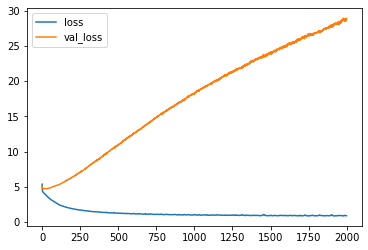

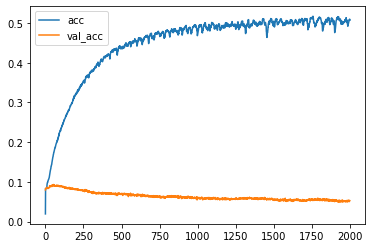

In [16]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [17]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [18]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [19]:
print(np.array([[ word2idx['<sos>'] ]]))

[[1]]


In [28]:
def sample_line():
    # initial inputs
    np_input = np.array([[ word2idx['<sos>'] ]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))
    # so we know when to quit
    eos = word2idx['<eos>']
    # store the output here
    output_sentence = []
    for _ in range(max_sequence_length):
        o, h, c = sampling_model.predict([np_input, h, c])
        probs = o[0,0]
        if np.argmax(probs) == 0:
            print("wtf")
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break
        # accuulate output
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))
        # make the next input into model
        np_input[0,0] = idx

    return ' '.join(output_sentence)

In [29]:
# generate a 4 line poem
while True:
    for _ in range(4):
        print(sample_line())
    ans = input("---generate another? [Y/n]---")
    if ans and ans[0].lower().startswith('n'):
        break

we may as well see that and save the day.'
by tying together growing wild,
some zealous one's laborious device.
as gilt to gold that should hour
---generate another? [Y/n]---n
